![logo](http://www.stickpng.com/assets/images/5a2fe3efcc45e43754640848.png)

___

# What are some characteristic features of Twitter activity associated with the aftermath of a mass shooting?
___

### Authors
* Nikhil Bose (A12956077)
* Audrey Chung (A12735963)
* Lindy Hernandez (A92071779)
* Alvin Vanegas (A13103130)
* John Yoon (A13036250)

# **Many of the visualizations shown below (created by 'bokeh') are interactive. Unfortunately, this also means that they cannot be viewed on Github. Please either download this notebook and open locally, or use the following link to load the notebook in your browser.** https://nbviewer.jupyter.org/

___

## 1. Introduction and Background
___

It's a fact that nearly a third of the world’s mass shootings have occured in the United States, a number which is higher than that of any other country. Americans are also more than three times as likely to use multiple weapons and are more likely to target schools, factories, and office buildings – places where gun violence shouldn’t be expected. On the other hand, shooters in other countries were more likely to strike in conflict-ridden areas like military bases (MotherJones). With the increase in use of social media to bring attention to public mass shootings, people have been able to voice out their opinions on issues surrounding these shootings, specifically gun control.

Twitter, the popular social media platform, is a source of real-time data pertaining to public opinion, thoughts, and feelings regarding recent events in the form of short messages or "tweets." Individual tweets can be accumulated and referenced based on hashtags, allowing for data to be collected easily en-masse, allowing for large-scale data analysis and natural language processing to be conducted.

Our group has focused on the analysis of three recent major mass shootings: Las Vegas, Sutherland Springs, and Parkland. We used the help of online Twitter scrapers, gathering over 35,000 tweets for each of the respective events. With this data set, our group is interested in quantifying public opinion and activity following each of these devastating mass shootings. By examining sentiment, volume, and salient figures we aim to identify some of the trends and characteristics that represent Twitter activity in the aftermath of each of these shootings. Our initial hypothesis is that there is enormous public outcry about the devastation of these shootings followed by immense pressures on political figures to take action. These can be quantified into: high tweet volume, numerous mentions of political figures, negative overall sentiment, and extremely low sentiment ratings of political figures and those associated with gun rights groups. Through use of modern machine learning and data science methods, we aim to validate the above hypothesis.

![Infographic](./Infographic.png)

___

## 2. Data Description

In [1]:
%reset
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from collections import defaultdict

import math
import string
import datetime
import re, copy
import random

from os import listdir
from os.path import splitext

from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.palettes import Accent3, Category20
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

output_notebook()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Loading BokehJS ...

### 2A. Data Collection

> According to Merriam-Webster, a hashtag is _“a word or phrase preceded by the symbol # that classifies or categorizes the accompanying text”_.

As a result, our team focused our analysis to the population of tweets which contain relevant hashtags. In order to analyze Twitter activity associated with mass shootings, we first needed to identify individual hashtags of interest. These hashtags were manually gathered by navigating to Twitter's hashtag timelines and viewing the entries listed under _“Related searches”_.

> Some hashtags were excluded from our analysis on account of ambiguity. For example, although _“#vegas”_ was identified as trending, we were unable to programmatically distinguish between the tweets that did or did not specifically refer to the Mandalay Bay shooting.

Tweets for each identified hashtag was then scraped using the [twitterscraper](https://github.com/taspinar/twitterscraper) library. A standard set of arguments was provided to the command-line tool for each web scraping operation to specify the following behavior.
1. Only gather tweets written in English
2. Only gather tweets created within a span of seven days from the shooting

`twitterscraper "#parkland" -bd 2018-02-14 -ed 2018-02-22 --lang en -o parkland.json > parkland.err`

In [2]:
source_dir = 'minisets'
output_dir = 'datasets'

# Tweets scraped from each hashtag are stored in individual JSON files (e.g. #vegasshooting -> vegasshooting.json)
mappings = {
    'parkland' : [ 'parkland', 'parklandshooting', 'parklandschoolshooting', 'floridaschoolshooting'],
    'sutherland' : [ 'sutherlandsprings', 'sutherlandspringsshooting' ],
    'vegas' : [ 'vegasshooting', 'lasvegasshooting' ]
}

def load_miniset(hashtag):
    twitter_df = pd.read_json(source_dir + '/' + hashtag + '.json')
    print('Loaded miniset for #{} with {} rows.'.format(hashtag, twitter_df.shape[0]))
    
    # Resort tweets by their timestamps from oldest to newest
    twitter_df = twitter_df.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)
    return twitter_df

### 2B. Raw Data Statistics

The following provides a list of hashtags used for analysis, as well as the number of tweets scraped from each. These numbers reflect datasets that span slightly more than seven days as the “twitterscraper” library is only able to scrape tweets on the specificity of individual days.

**1. Stoneman Douglas High School (Parkland, FL) - 218,920**
 * #parkland - 108,618
 * #floridaschoolshooting - 47,107
 * #parklandschoolshooting - 33,381
 * #parklandshooting - 29,814

**2. First Baptist Church (Sutherland, TX) - 39,683**
 * #sutherlandsprings - 34,292
 * #sutherlandspringsshooting - 5,391

**3. Mandalay Bay (Las Vegas, NV) - 150,827**
 * #lasvegasshooting - 120,118
 * #vegasshooting - 30,709
 
> _**Note:** The code below comments out the loading of unparsed datasets as only the cleaned data is retained._

In [3]:
datasets = {}
# for index, hashtags in mappings.items():
#     datasets[index] = pd.concat((load_miniset(hashtag) for hashtag in hashtags), ignore_index=True)
#     print("Concatenated {} rows into dataframe for index '{}'\n".format(datasets[index].shape[0], index))

___

## 3. Data Cleaning / Pre-processing

### 3A. Identification of 'Origin' Tweets

One of the first actions we needed to take was to identify the ‘origin’ tweet for each mass shooting.

> We define the ‘origin’ tweet as the first relevant tweet, post-shooting, that contains a particular hashtag.

Identifying the origin is necessary to deal with hashtag ambiguity. In the case of #parkland, for example, tweets from local businesses were created in between the time of the associated shooting and the time of the first relevant tweet.
1. The origin is manually identified by parsing the first several tweets created post-shooting.
2. Tweets created outside the period of analysis (i.e. within seven days of the origin) were filtered from the dataset.
3. The tweets were then grouped by creation time into 30 minute intervals.

In [4]:
# The following line displays immediately preceding tweets
# df[df.timestamp <= origin].sort_values(by='timestamp', ascending=True).text[-5:]

# Timestamps of pre-identified origin tweets
origins = {
    'parkland': pd.Timestamp(2018,2,14,19,38,44),
    'sutherland': pd.Timestamp(2017,11,5,18,39,49),
    'vegas': pd.Timestamp(2017,10,2,5,26,47)
}

for key, df in datasets.items():
    print("[{}]".format(key))
    
    origin = origins[key]
    cutoff = origin + pd.Timedelta('7d')
    
    # Removes tweets that are out of scope
    datasets[key] = df[(df.timestamp >= origin) & (df.timestamp <= cutoff)].reset_index(drop=True)
    final_ts = datasets[key].timestamp.max()
    
    print("Data for index '{}' spans a range of {}".format(key, final_ts - origin))
    
    # Round each timestamp (30 min) as an offset from the origin
    ts_origin = df['timestamp'].min()
    df['ts_30m'] = df['timestamp'].apply(lambda ts: (ts - ts_origin).round('30 min'))
    
    print('\n'.join([ "Origin: {}".format(origin), "Cutoff:  {}".format(cutoff) ]))
    print(df[df.timestamp == origin].text.iloc[0] + '\n')

### 3B. Data Cleaning & Anonymization

After considering the dimensions of the data provided by “twitterscraper”, we dropped the columns “fullname”, “html”, “id”, and “url”. Instead of dropping the “user” column, however, we chose to instead anonymize it by assigning a random numeric UID to each unique username.

In [5]:
for key, df in datasets.items():
    print("Anonymizing data for the index {}".format(key))
    # Dropping sensitive dimensions
    if 'fullname' in df.columns:
        datasets[key] = df.drop(labels=['fullname', 'html', 'id', 'url'], axis=1)
    
    # Anonymizing users by assigning randomly generated UIDs
    datasets[key]['user'] = df['user'].map(
        pd.Series(
            random.sample(range(10000000), len(df.user.unique())),
            index=df.user.unique()
        )
    )

Finally, we removed duplicated tweets that were scraped multiple times over different hashtags. (e.g. tweets containing both “#lasvegasshooting” and “#vegasshooting”).

In [6]:
for key, df in datasets.items():
    print("Removing duplicate rows for the index {}".format(key))
    indices = df.columns.tolist()
    datasets[key] = df[~df.duplicated(subset=indices)]

The following provides the resultant number of tweets collected for each dataset.

**1. Stoneman Douglas High School (Parkland, FL) - 202,851 (-7.34%)**
 * #parkland, #parklandschoolshooting, #parklandshooting, #floridaschoolshooting

**2. Mandalay Bay (Las Vegas, NV) - 148,098 (-1.81%)**
 * #lasvegasshooting, #vegasshooting

**3. First Baptist Church (Sutherland, TX) - 39,232 (-1.14%)**
 * #sutherlandsprings, #sutherlandspringsshooting
 
___

## 4. Data Visualization

### 4A. Loading Pre-Processed Data

In [7]:
load_data = lambda fname: pd.read_json(fname).sort_index(ascending=True)

basedir = './datasets/'
fnames = listdir(basedir)

# Mapping filename to associated datasets
datasets = dict( (splitext(fn)[0][:-2], load_data(basedir + fn)) for fn in fnames )
for key, df in datasets.items(): df['ts_30m'] = pd.to_timedelta(df['ts_30m'], unit='ms')

for key, df in datasets.items():
    print('Loaded {} rows for the index {}'.format(df.shape[0], key))
    
    origin_ts = origins[key]
    print('Origin tweet created at time {}'.format(origin_ts))
    print(df[df.timestamp == origin_ts].text.iloc[0] + '\n')

Loaded 202851 rows for the index parkland
Origin tweet created at time 2018-02-14 19:38:44
Police activity. in #Parkland on Coral Springs Dr at Holmberg Rd #SFLtraffic http://bit.ly/14TxRiy 

Loaded 39232 rows for the index sutherland
Origin tweet created at time 2017-11-05 18:39:49
#SutherlandSprings has a #Church Shooting?

Loaded 148098 rows for the index vegas
Origin tweet created at time 2017-10-02 05:26:47
Security guard shot in leg on 32nd floor (unk hotel) #VegasShooting



### 4B. Visualizing Tweet Volume

Due to the wide breadth of timestamps across the set of collected tweets, it was necessary to first collect tweets into 30 minute interval bins in order to generate smoother timeseries visualizations.

> Each tweet is rounded to the nearest 30 minute offset (relative to the origin tweet)

In [8]:
# Create a range of 30 minute intervals, spanning a seven day period (X-Axis)
td_range = [ pd.Timedelta(str(30 * i) + 'm') for i in range((7 * 24 * 2) +1) ]
# (key, pd.Series containing tweet volume)
tweet_vol = {}

for key, df in datasets.items():
    print("Calculating tweet volume for the {} index...".format(key))
    
    # Count volume of tweets generated within each 30 minute interval
    num_tweets = df.groupby('ts_30m')['text'].count()
    num_tweets = num_tweets.reindex(td_range, fill_value=0)
    
    tweet_vol[key] = num_tweets.values

Calculating tweet volume for the parkland index...
Calculating tweet volume for the sutherland index...
Calculating tweet volume for the vegas index...


The following graph portrays the trends in Tweet volume over time for each event.  
It also estimates local maximas (i.e. times at which the volume of new Tweets peak)

In [9]:
from scipy.stats import sem
from scipy.signal import find_peaks_cwt

plots = []
peak_dists = []

for pair, color in zip(tweet_vol.items(), Accent3):
    p = figure(
        title="Tweet Volume Over Time",
        x_axis_label="Time offset from origin", x_axis_type="datetime",
        y_axis_label="Volume",
        plot_width=800, plot_height=300
    )
    
    # Graph Tweet volume over time
    p.line(
        x=td_range, y=pair[1],
        color=color, line_width=2,
        legend=pair[0]
    )
    
    # Estimate local maximas over time
    peaks = find_peaks_cwt(pair[1], widths=[8]) * pd.Timedelta('30min')
    p.segment(x0=peaks, y0=[0] * len(peaks),
          x1=peaks, y1=[5000] * len(peaks),
          color=color)
    
    # Store average & std error of distances between peaks
    pk = np.diff([0] + peaks.tolist())
    avg_dist = pd.to_timedelta(sum(pk) / len(pk))
    dist_sem = pd.to_timedelta(sem(pk))
    
    peak_dists.append((avg_dist, dist_sem))
    plots.append(p)

show(column(plots))

### 4C. Visualizing Number of Active Tweeters

The number of users tweeting during each 30 minute interval is determined by counting the number of unique IDs under the user column (which was re-randomized during the data processing step).

In [10]:
tweeters = dict()
for key, df in datasets.items():
    print("Calculating number of tweeters for the {} index...".format(key))
    
    # Count volume of tweets generated within each 30 minute interval
    num_users = df.groupby('ts_30m').user.unique().apply(len)
    num_users = num_users.reindex(td_range, fill_value=0)
    
    tweeters[key] = num_users.values

Calculating number of tweeters for the parkland index...
Calculating number of tweeters for the sutherland index...
Calculating number of tweeters for the vegas index...


The following graph portrays the trends in number of active Tweeters over time.  
It is also overlaid with Tweet volume (as a dashed/dotted line)

In [11]:
p = figure(
    title="Number of Active Tweeters Over Time",
    x_axis_label="Time offset from origin", x_axis_type="datetime",
    y_axis_label="Number of Active Tweeters",
    plot_width=800, plot_height=300
)

keys = [ 'parkland', 'sutherland', 'vegas' ]
for key in keys:
    color = Accent3[keys.index(key)]

    # Graph number of active tweeters over time
    pair = key, tweeters[key]
    p.line(
        x=td_range, y=pair[1],
        color=color, line_width=2,
        legend=pair[0]
    )

    # Graph Tweet volume over time
    pair2 = key, tweet_vol[key]
    p.line(
        x=td_range, y=pair2[1],
        color=color, line_dash='dashdot',
        legend=pair2[0] + ' (Tweet vol.)'
    )

show(p)

### 4D. Visualizing Tweet Density

> Tweet density is defined as the ratio between the volume of tweets to the number of active tweeters.

In [12]:
# Note: RuntimeWarning can be ignored due to entries in index 'sutherland_c' having a value of 0
tweets_per_tweeter = dict()

for key, df in datasets.items():
    print("Calculating tweet density for the {} index...".format(key))
    
    ratio = pd.Series(tweet_vol[key] / tweeters[key])
    ratio.index = td_range
    
    tweets_per_tweeter[key] = ratio.values

Calculating tweet density for the parkland index...
Calculating tweet density for the sutherland index...
Calculating tweet density for the vegas index...


C:\Users\Forager\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


The following graph portrays the trends in tweet density over time.

In [13]:
p = figure(
    title="Tweet Density",
    x_axis_label="Time offset from origin", x_axis_type="datetime",
    plot_width=800, plot_height=300
)

for pair, color in zip(tweets_per_tweeter.items(), Accent3):
    p.line(
        x=td_range, y=pair[1],
        color=color, line_width=2,
        legend=pair[0]
    )

show(p)

## 4E. Word Clouds

The following cell extracts the number of hashtags present within each tweet.

In [14]:
# Function goes thru dataframe and gets the counts for each hash tag used sorted
def get_hash_tags_counts(data):
    setToRemove = string.punctuation
    setToRemove = setToRemove.replace('#',"")
    pattern = r"[{}]".format(setToRemove) # create the pattern
    
    hash_tag_counts = defaultdict(int)
    df_text = data['text']
    df_text = df_text.str.lower()
    for tweet in df_text:
        # strip punctuation from sentnece
        tweet = re.sub(pattern, "", tweet)
        for word in tweet.split():
            if '#' in word:
                hash_tag_counts[word] += 1
    hash_tag_counts = [(hash_tag_counts[w], w) for w in hash_tag_counts]
    hash_tag_counts.sort()
    hash_tag_counts.reverse()
    return hash_tag_counts

This following cell portrays word clouds of the top 25 most used hashtags in each of the three datasets.

Parkland Shooting


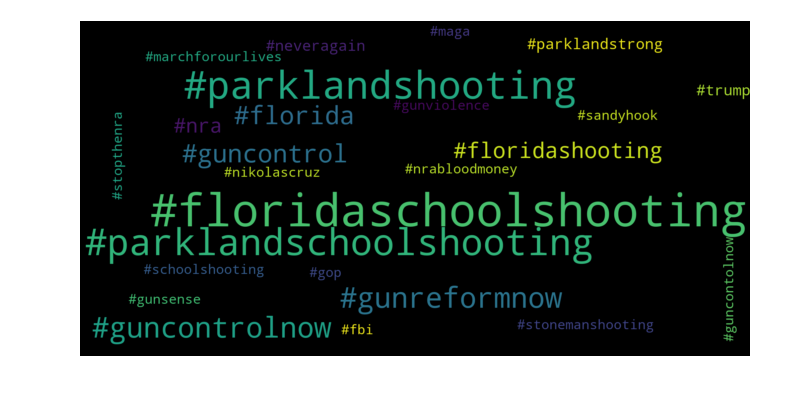

Sutherland Shooting


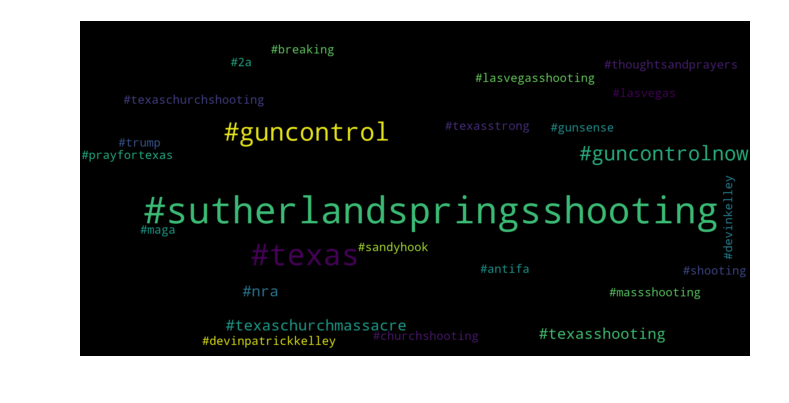

Las Vegas Shooting


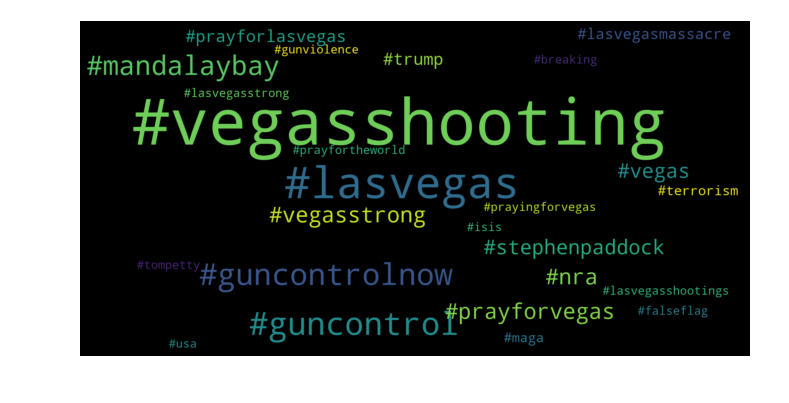

In [15]:
from wordcloud import WordCloud

# Function displays word cloud given the counts
def display_word_cloud(counts):
    # Generate wordcloud
    count_dict = dict( [ (x[1],x[0]) for x in counts[1:26] ] )
   
    wc = WordCloud(background_color="black", scale=5)
    wc.generate_from_frequencies(count_dict)
    
    # Display the generated image:
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

    plt.show()
    
# Get the list of sets of hashtags and their counts
counts_park = get_hash_tags_counts(datasets['parkland'])
counts_vegas = get_hash_tags_counts(datasets['vegas'])
counts_suth = get_hash_tags_counts(datasets['sutherland'])

print("Parkland Shooting")
display_word_cloud(counts_park)
print("Sutherland Shooting")
display_word_cloud(counts_suth)
print("Las Vegas Shooting")
display_word_cloud(counts_vegas)

## 5. Data Analysis and Results



In [16]:
import scipy as sp

import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize,TweetTokenizer,MWETokenizer
from nltk.collocations import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import seaborn as sns
sns.set(color_codes=True)

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

C:\Users\Forager\Anaconda2\envs\py36\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 5A. Word-Frequency Analysis

Due to variabilities in language, the tweets must be standardized to ensure that we can accurately quantify metrics such as frequency and sentiment. For example, although as humans we automatically recognize and associate synonyms, those synonyms will significantly alter a variety of statistics such as word frequency.

> The following cell standardizes the content of Tweets in order to allow us to manage these inconcisistencies.

In [17]:
def standardize_tweet(t):
    #make all tweets lower, and strip trailing/following whitespace
    t = t.lower()
    t = t.strip()
    
    #removing pictures
    if(t.find('pic.twitter.com') != -1):
        i = t.find('pic.twitter.com')
        t = t[0:i]
    #removing links
    if(t.find('https://') != -1):
        h = t.find('https://')
        j = t.find("\xa0")
        if(j == -1):
            j = t.find('…')
        remove1 = t[h:j+1]
        t = t.replace(remove1,'')
    elif(t.find('http://') != -1):
        h = t.find('http://')
        j = t.find("\xa0")
        if(j == -1):
            j = t.find('…')
        remove1 = t[h:j+1]
        t = t.replace(remove1,'')
    elif( t.find('www.') != -1):
        h = t.find('www.')
        j = t.find("\xa0")
        if(j == -1):
            j = t.find('…')
        remove1 = t[h:j+1]
        t = t.replace(remove1,'')
     
    #decoding ASCII/UTF-8 encoding to English
    t = t.replace("&","and")
    t = t.replace('\n', '')
    t = t.replace("\'",'')
    
    # NRA was a prominent figure in our analysis
    # They had muliple aliases here were are converting so they can be properly counted 
    t  = t.replace("#nra",'nra')
    t = t.replace("national rifle association",'nra')
    
    #same with GOP
    t = t.replace("@housegop","@gop")
    t = t.replace("@senategop","@gop")
    
    #and MAGA  
    t = t.replace("make america great again",'maga')    
    t = t.replace('#maga','maga')
    
    #lots of similar terms for 'Gun Reform'
    t = t.replace("#gunreformnow",'#guncontrolnow') 
    t = t.replace("gun policy",'gun control')
    t = t.replace("gun reform",'gun control')
    t = t.replace("gun law reform",'gun control')
    
    # A common weapon with different spellings
    t = t.replace("ar 15",'ar15')
    t = t.replace("ar-15",'ar15')

    #ensuring consistency of location
    t = t.replace("fla","florida")
    t = t.replace("nv","nevada")
    t = t.replace("tx","texas")
    
    t = t.replace("representative","rep")
    # Paul Ryan has many twitter handles, we wanted to make 
    # sure that all his mentions were accouted for
    t = t.replace("@reppaulryanvp","@speakeryan")
    t = t.replace("@pryan","@speakeryan")

    #Same with Donald Trump, and Barack Obama
    t = t.replace("@potus","@realdonaldtrump")
    #many spellings for 2nd Amendment
    t = t.replace("second amendment","2nd amendment")
    
    return t

In [18]:
# Applying the standardization to each dataset
p_tweets = datasets['parkland']['text'].apply(standardize_tweet).values
lv_tweets = datasets['vegas']['text'].apply(standardize_tweet).values
ss_tweets = datasets['sutherland']['text'].apply(standardize_tweet).values

## 5B. Word-Frequency Analysis

We can start with our first major analysis of the cleaned text. Word-Frequency provides some of the most basic statistics we can find through text analysis, but it serves as useful stepping stone from which to continue further analysis. By counting frequencies, we can gain insight into common words & phrases. This provides a characterization of the overall public response to these shootings.

Throughout our Word-Frequency analysis, we used components and APIs from the NLTK library for Natural Language Processing. The use of NLTK's social media optimized tokenizers, lemmatizers and collocations reduced our workflow immensely. 

### 1. Basic FreqDist Approach

The following cell uses a FreqDist data structure to provide a understanding of specific word frequency.  
This allows us to reveal relative and absolute frequencies for individual words.

In [19]:
def get_frequencies(tweets):
    #construct FreqDist
    fdist = FreqDist()
    # "Tokenize" or split into individual words
    tknzr = TweetTokenizer(reduce_len=True)
    # construct lemmatizer
    lemma = nltk.wordnet.WordNetLemmatizer()
    ignored_words = nltk.corpus.stopwords.words('english')
    for tweet in tweets:
        for word in tknzr.tokenize(tweet):
            #lemmatize word
            word = lemma.lemmatize(word)
            if word not in ignored_words and word != "!" and word != "?" and word != "." and word != '...':
                fdist[word] += 1
    return fdist

The following cell shows the 20 most common words used within Tweets created after each event.

Parkland


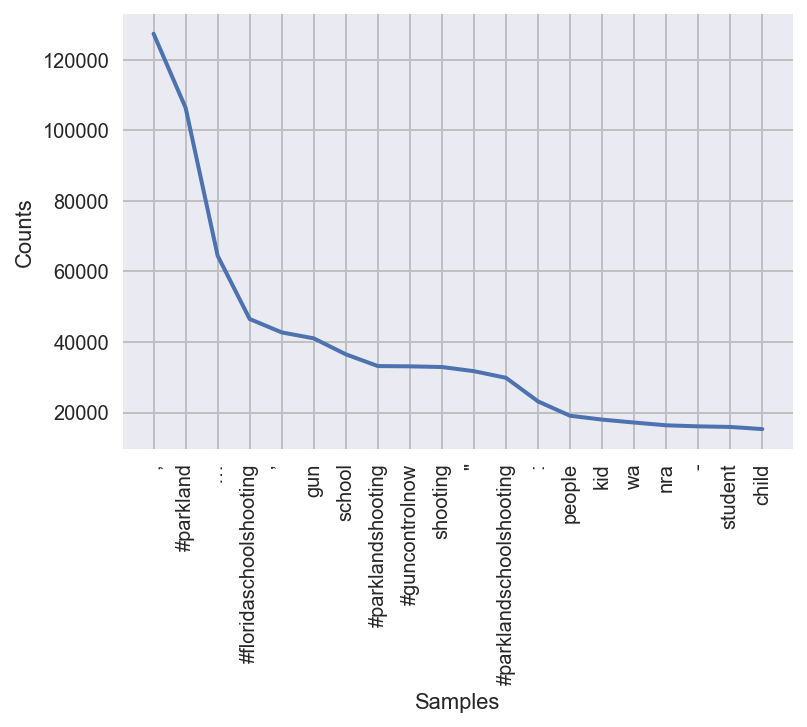

Sutherland Springs


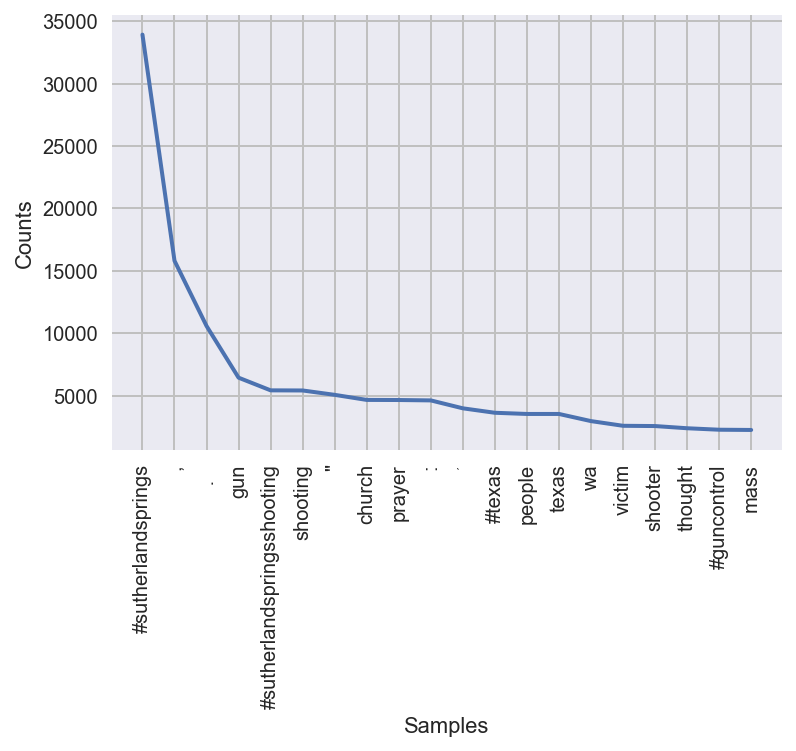

Las Vegas


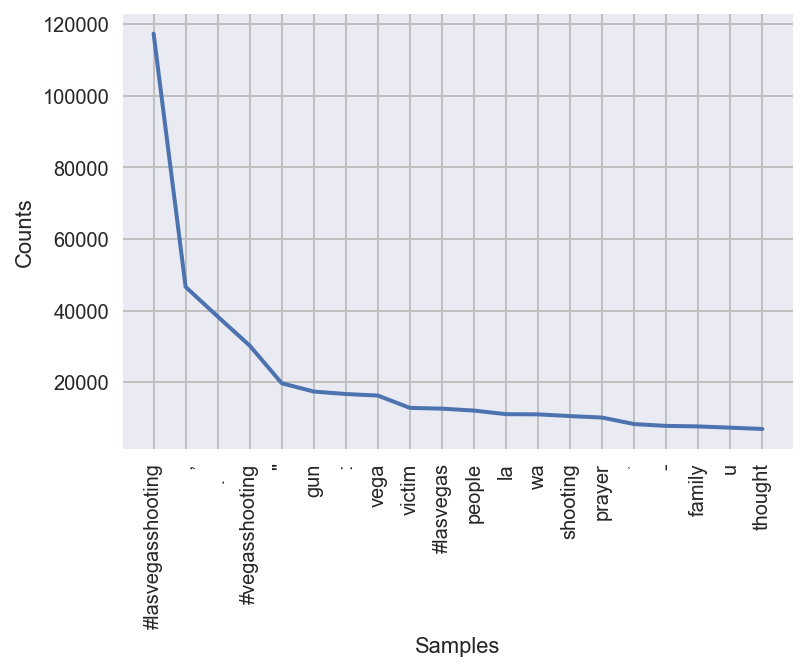

In [20]:
# Create individual FreqDists for each dataset
p_freq = get_frequencies(p_tweets)
ss_freq = get_frequencies(ss_tweets)
lv_freq = get_frequencies(lv_tweets)

# Plot the top 20 words from the FreqDist from each shooting
print('Parkland')
p_freq.plot(20)
print('Sutherland Springs')
ss_freq.plot(20)
print('Las Vegas')
lv_freq.plot(20)

Unsurprisingly, the word **gun** is prominent, appearing across all tweets.  
Conversely, many commonly appearing words are specific to the situation.

For Parkland, there were more youth-related words such as **school**, **kid** and **student**.  
Similarly, Sutherland Springs had religion oriented words such as **church** and **prayer**.

However, it is evident that we will need to apply measures of frequency more sophisticated than that of simple word counts. Even after applying tweet-sensitive tokenization and lemmatization, we ended up counting many irrelevant words and hashtags. The enormous count of the hashtags have to be completely ignored, since they are the binding reference between all of these tweets in the first place!

>**Note:** More complex Regular Expression based tokenizers could be used to remove some of the punctuation mark-based "words". However, we decided to move in favor of the twitter-focused tokenizer and manually "removed" the punctuation marks from the FreqDist.

Finally, as shown in the cell below, we can analyze how pertinent certain words are to the overall conversation with regards to each event.

In [21]:
mappings = {
    'parkland' : p_freq,
    'sutherland' : ss_freq,
    'vegas' : lv_freq
}

print("[Appearance of 'control' within Tweets]")
for key, fr in mappings.items():
    filtered = [ word for word in fr.keys() if 'control' in word ]
    total = sum(fr.values())
    control = sum([ fr[word] for word in filtered ])
    
    print("{}: {:.3%} ({})".format(key, (control / total), control))

print("\n[Appearance of 'victim' within Tweets]")
for key, fr in mappings.items():
    filtered = [ word for word in fr.keys() if 'victim' in word ]
    total = sum(fr.values())
    control = sum([ fr[word] for word in filtered ])
    
    print("{}: {:.3%} ({})".format(key, (control / total), control))

[Appearance of 'control' within Tweets]
parkland: 1.630% (56780)
sutherland: 1.220% (5586)
vegas: 1.017% (16794)

[Appearance of 'victim' within Tweets]
parkland: 0.331% (11541)
sutherland: 0.582% (2664)
vegas: 0.807% (13315)


### 2. Frequency of Popular Phrases

Using a tokenizer allows specific phrases to be counted as a single 'word'.  
The following cell trains the tokenizer to recognize some pre-identified phrases commonly associated with mass shootings.

In [22]:
mappings = {
    'parkland' : p_tweets,
    'sutherland' : lv_tweets,
    'vegas' : lv_tweets
}

tokenizer = MWETokenizer()
ignored_words = nltk.corpus.stopwords.words('english')

tokenizer.add_mwe(('thoughts', 'and', 'prayers'))
tokenizer.add_mwe(('gun','control'))
tokenizer.add_mwe(('mental','health'))
tokenizer.add_mwe(('donald','trump'))

fdists = dict( zip(mappings.keys(), [ FreqDist() for x in range(len(mappings)) ]) )

for key, tweet_set in mappings.items():
    for tweet in tweet_set:
        for word in tokenizer.tokenize(tweet.split()):
             if word not in ignored_words and word != "!" and word != "?" and word != "." and word != '...':
                    fdists[key][word] += 1

The following cell portrays bar charts of the counts associated with each phrase.

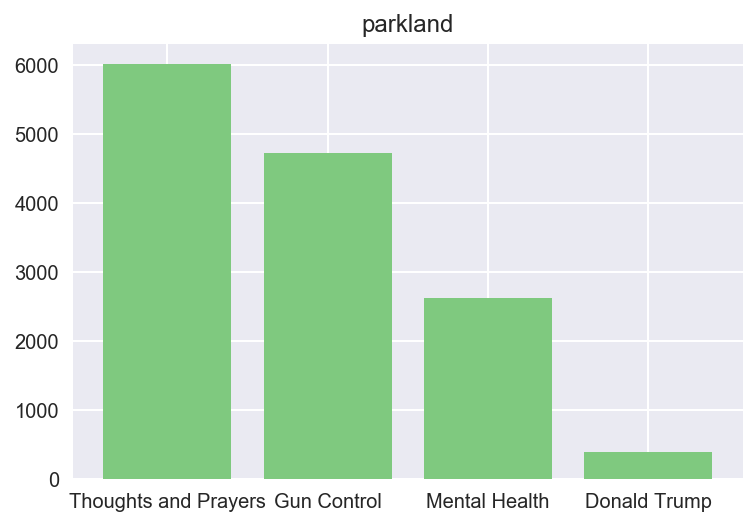

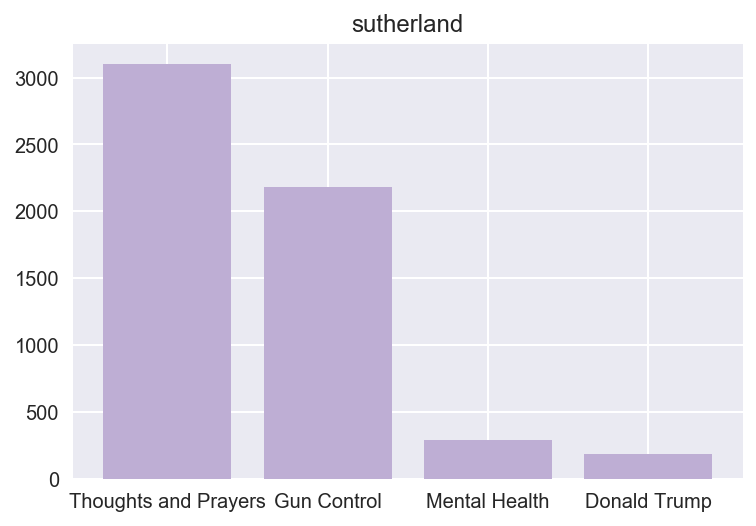

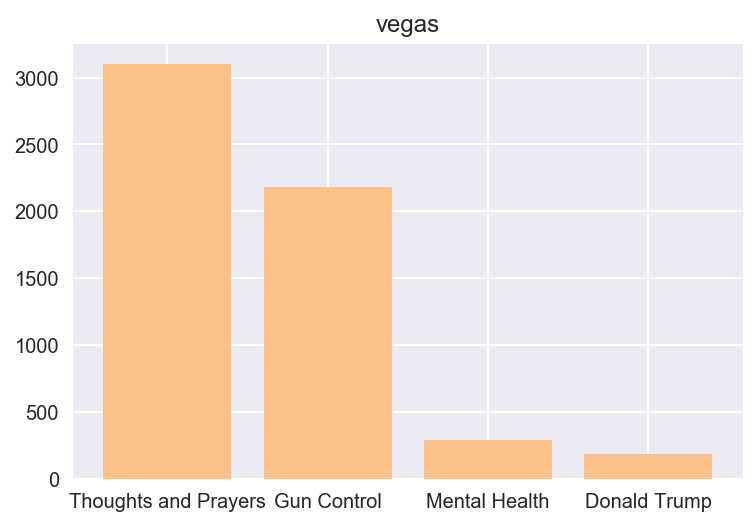

In [23]:
for pair, color in zip(fdists.items(), Accent3):
    key, fdist = pair
    
    t_a_p = fdist['thoughts_and_prayers']
    gun_control = fdist['gun_control']
    mh = fdist['mental_health']
    dtrump = fdist['donald_trump']

    x = ['Thoughts and Prayers', 'Gun Control', 'Mental Health', 'Donald Trump']
    y = [t_a_p, gun_control, mh, dtrump]

    plt.bar(x, y, color=color)
    plt.title(key)
    plt.show()

The bar charts above measure the relative frequency of common phrases/concepts captured in media. For example, "Thoughts and Prayers" is in fact a popular substring - but what is the context behind their actual occurrences? Knowing whether "Gun Control" is part of a tweet does not provide us any indication as to whether the user is speaking in a positive or a negative tone.

With the MWT tokenizer, it is possible to capture the frequencies of specific phrases, but it is hard to understand which phrases/words occur naturally together - here we are searching for the specific frequencies of certain well known strings - but what about combinations we may not know about?

## 5C. Trigram Level Collocations

The Collocations method is a more robust way of finding words that commonly co-occur by checking relative locations vs. frequency in the Corpus and the PMI index, allowing us to filter out potential noise phrases. We again want to eliminate any potential phrases that contain stop words, or have short words, meaning that they contain pronouns or punctuation marks.

We conducted the collocation anaylsis at the trigram level (i.e. checking for 3 words sequences that commonly appear together) as we ended up simply finding that many of the two-word sequences were simply nonsense.

In [24]:
def get_collocations(tweets):
    #Create Trigram Collocation object to measure dependencies 
    # between a 3-set of words
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    # Use tweet sensitive tokenizer
    tknzr = TweetTokenizer(reduce_len=True)
    # create library of get rid of stopwords
    ignored_words = nltk.corpus.stopwords.words('english')
    cfd = FreqDist()
    for text in tweets:
        tokens = tknzr.tokenize(text)
        finder = TrigramCollocationFinder.from_words(tokens)
        #get rid of stopwords and short words
        finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)

        #Make sure that the trigram is something that is actually important
        if(len(tuple(nltk.trigrams(tokens))) != 0):
            collocation = sorted(finder.above_score(trigram_measures.raw_freq,1.0/ len(tuple(nltk.trigrams(tokens)))))
        if(len(collocation)>0):
            cfd[collocation[0]] += 1
    return cfd

The following cell portrays the number of times each trigram appeared across the tweets.

In [25]:
p_cfd = get_collocations(p_tweets)
lv_cfd = get_collocations(lv_tweets)
ss_cfd = get_collocations(ss_tweets)

# Retrieves the 5 most common trigrams across the entire population
p_colloc = p_cfd.most_common(5)
lv_colloc = lv_cfd.most_common(5)
ss_colloc = ss_cfd.most_common(5)

d = dict()
for c in p_colloc:
    key = c[0]
    value = c[1]
    if key in d:
        d[key]+=value
    else:
        d[key] = value
for c in lv_colloc:
    key = c[0]
    value = c[1]
    if key in d:
        d[key]+=value
    else:
        d[key] = value
for c in ss_colloc:
    key = c[0]
    value = c[1]
    if key in d:
        d[key]+=value
    else:
        d[key] = value

d

{('#crisisactor', '#davidhogg', '#crisisactor'): 11,
 ('#neveragain', '#neveragain', '#neveragain'): 17,
 ('2016', 'election', 'cycle'): 11,
 ('blah', 'blah', 'blah'): 3,
 ('ceo', 'jim', 'murren'): 2,
 ('debate', 'gun', 'control'): 3,
 ('devin', 'patrick', 'kelley'): 2,
 ('dont', 'kill', 'people'): 2,
 ('fake', 'fake', 'fake'): 5,
 ('guns', 'dont', 'kill'): 12,
 ('kill', 'people', '...'): 2,
 ('know', 'well', 'enough'): 1,
 ('mental', 'health', 'issues'): 20,
 ('need', 'gun', 'control'): 1}

We can see through the analysis above that "Mental Health Issues" is clearly a significant topic with respect to each of the events.

## 5D. Sentiment Analysis

Sentiment analysis is a way to quantify both public opinion and polarity. For our purposes, we can use it to gain a better understanding into how people felt in the aftermath of each mass shooting. Moreover, we can apply sentiment analysis to quantify how people felt towards specific people, concepts or ideas.

We used VADER, a pretrained sentiment analyzsis model packaged with the NLTK library. This was vital for us to assess sentiment as restrictions on our available resources did not afford us time to create our own training data. As a result, we were unable to use conventional models. However, as VADER is trained on social media data, it is optimized for our use case.

In [26]:
#Function to get sentiment for a particular set of tweets
def get_sentiment(tweet_list):
    sid = SentimentIntensityAnalyzer()
    mention_sentiments = []
    for t in tweet_list:
        sentiment = sid.polarity_scores(t)
        s = sentiment['compound']
        mention_sentiments.append(s)
    
    return mention_sentiments

### 1. Overall Sentiment

The following cell portrays the distribution of tweets at each sentiment level.

C:\Users\Forager\Anaconda2\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



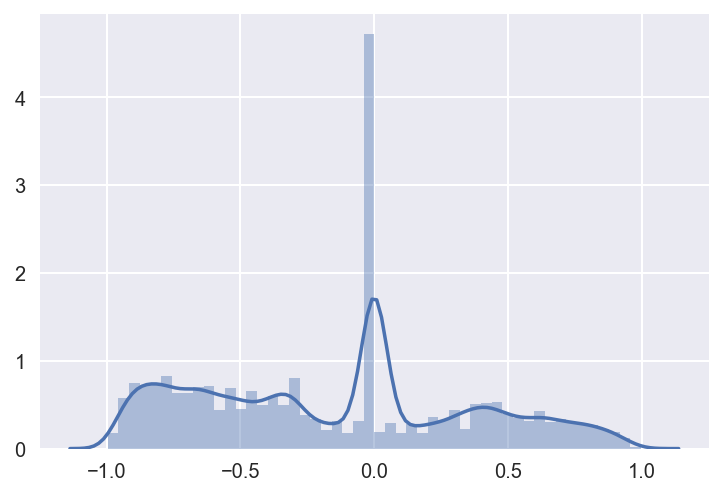

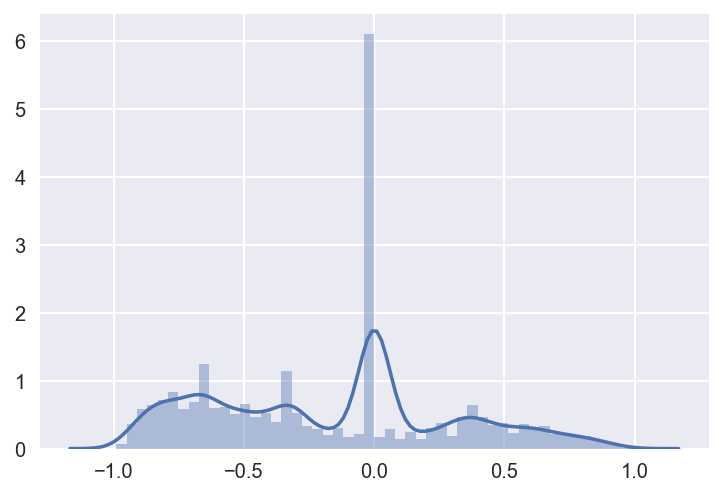

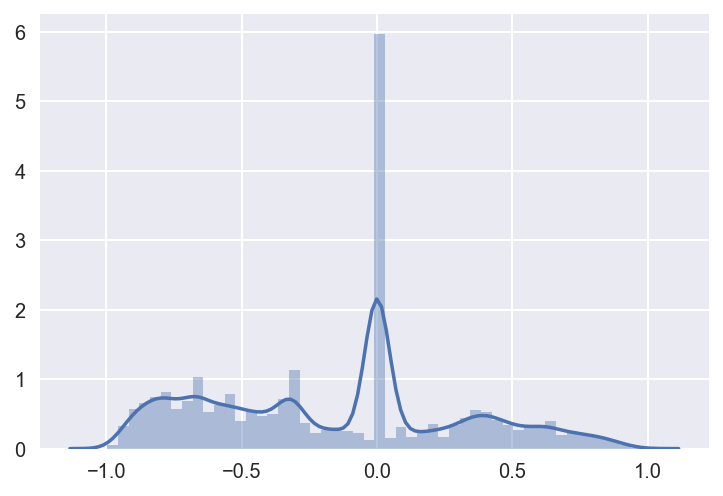

In [27]:
p_sentiment = get_sentiment(p_tweets)
lv_sentiment = get_sentiment(lv_tweets)
ss_sentiment = get_sentiment(ss_tweets)

sns.distplot(p_sentiment, kde=True, rug=False);
plt.show()

sns.distplot(ss_sentiment, kde=True, rug=False);
plt.show()

sns.distplot(lv_sentiment, kde=True, rug=False);
plt.show()

Above are the distribution of sentiment for the different shootings - we can see that there is a slight skew in the negative direction. This is congruent with the notion that the "average" sentiment after the parking shooting was negative - not suprising giving the magnitude of the situation. Parkland however, is the most skewed towards negatively - fueled by public outrage over the latest school shootings

## 2. Salient Figures

Now we will use sentiment analysis on Tweets that refer to the most mentioned Twitter handles in order to identify the most salient figures of the 3 events.  
The following cell uses the tokenizer to identify any handles mentioned across tweets.

In [28]:
#Only add to the FreqDist if it includes a handle
def get_mentions(tweets):
    mfd = FreqDist()
    mention_tknzr = TweetTokenizer(reduce_len=True)
    for tweet in tweets:
        for word in mention_tknzr.tokenize(tweet):
            if "@" in word:
                mfd[word] += 1
    return mfd

In [29]:
p_mentions = get_mentions(p_tweets)
lv_mentions = get_mentions(lv_tweets)
ss_mentions = get_mentions(ss_tweets)

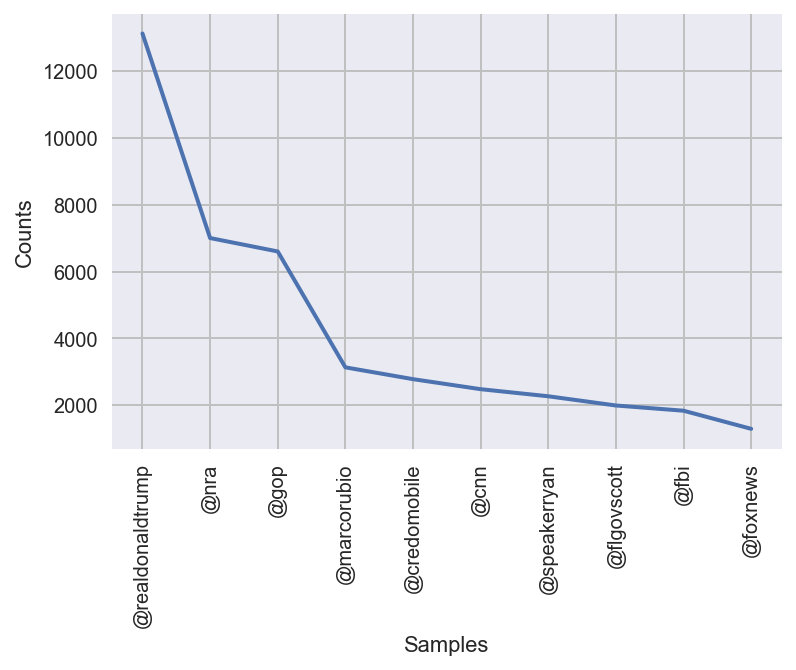

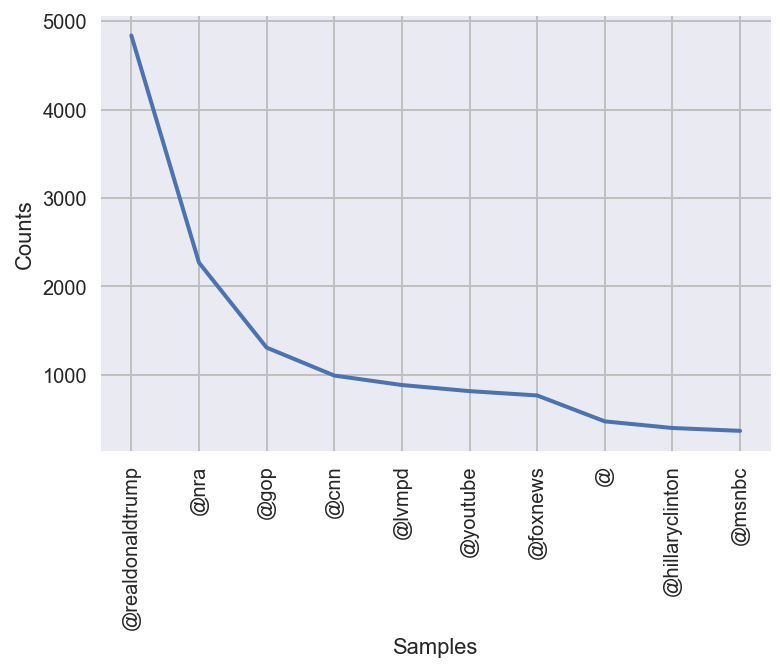

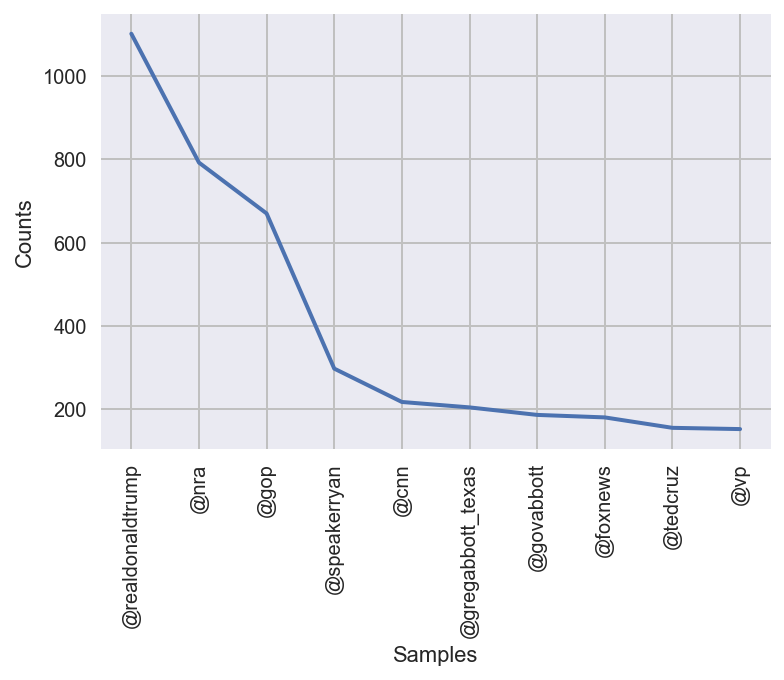

In [30]:
#Top 10 most mentioned usernames on Twitter
most_mentions_p = p_mentions.most_common(10)
p_mentions.plot(10)
lv_mentions.plot(10)
ss_mentions.plot(10)

The cell above shows the top 10 handles most references in the Parkland dataset - the list is notably virtually identical for Las Vegas and Sutherland Springs.

The President, Republican Party and the NRA were consistently the biggest recipient of mentions across the 3 datasets. Now that we've identified the salient figures, we can identify the sentiment towards each of them.

In [31]:
def get_figure_tweets(tweets):
    #get tweets referencing each of the following Twitter handles
    trump_tweets = list()
    nra_tweets = list()
    gop_tweets = list()
    #Obtain Tweets for each username
    for mention in tweets:
        if "@realdonaldtrump" in mention:
            trump_tweets.append(mention)
        elif "@nra" in mention:
            nra_tweets.append(mention)
        elif "@gop" in mention:
            gop_tweets.append(mention)
    return trump_tweets,nra_tweets,gop_tweets

In [32]:
#Get Sentiment for each Tweet referencing each handle
def get_sent_and_plot(t,n,g):
    t_sent = get_sentiment(t)
    n_sent = get_sentiment(n)
    g_sent = get_sentiment(g)
    return t_sent,n_sent,g_sent

In [33]:
#Plot sentiment for each figure
def sent_plotter(t,n,g):
    ax = sns.violinplot(x=t,jitter=True)
    plt.title('@realdonaldtrump')
    plt.show()
    
    ax = sns.violinplot(x=n,jitter=True)
    plt.title('@nra')
    plt.show()
    
    ax = sns.violinplot(x=g,jitter=True)
    plt.title('@gop')
    plt.show()

[Parkland]


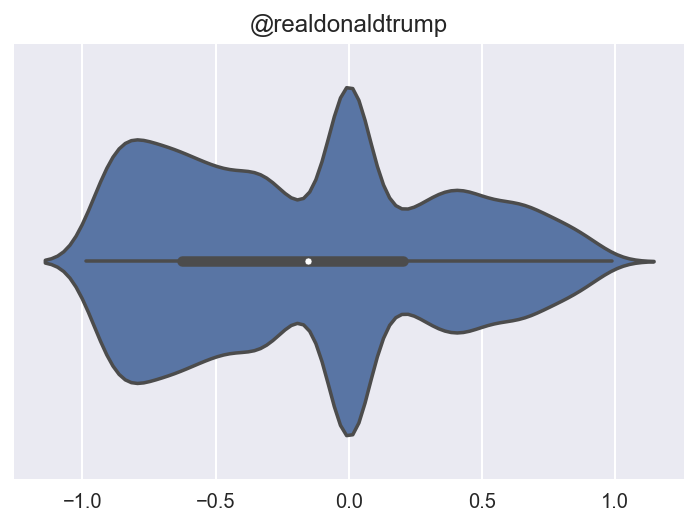

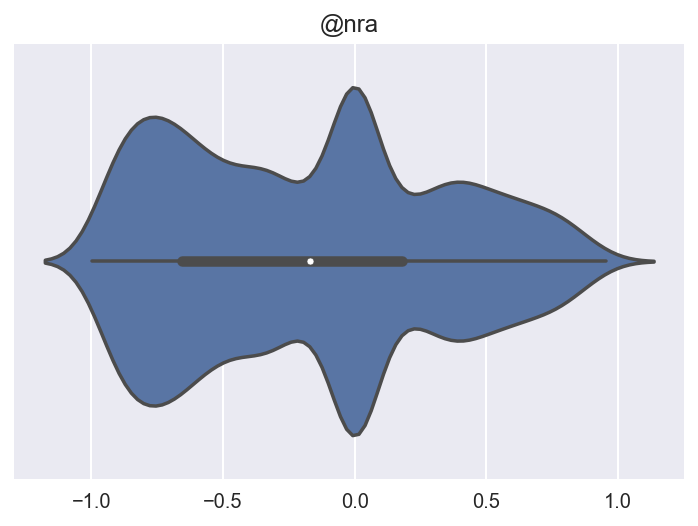

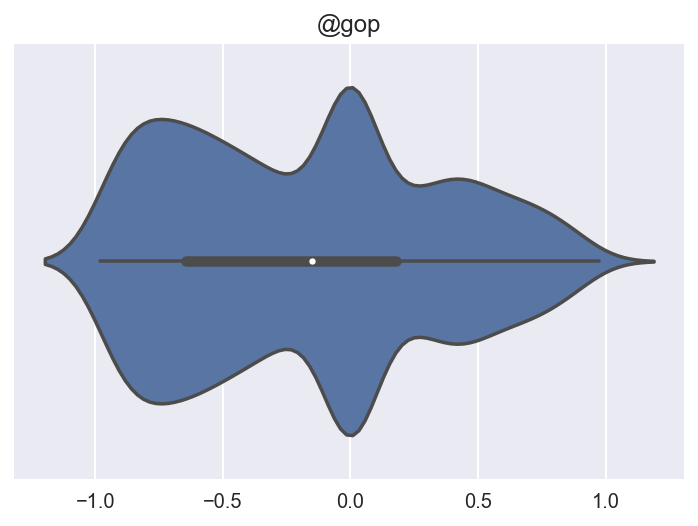

[Sutherland Springs]


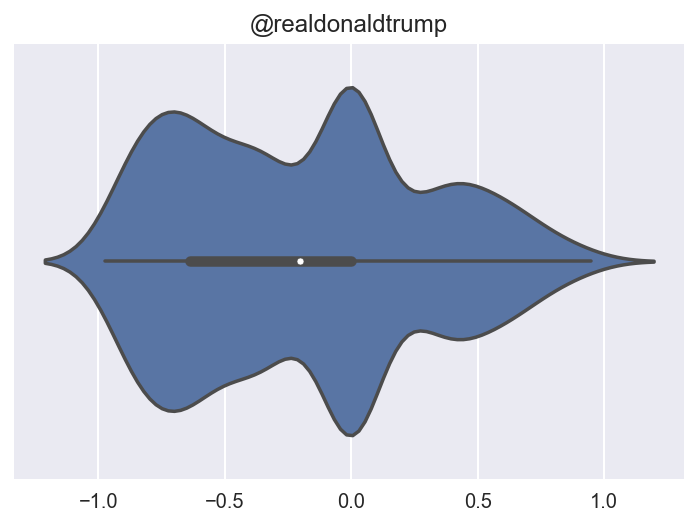

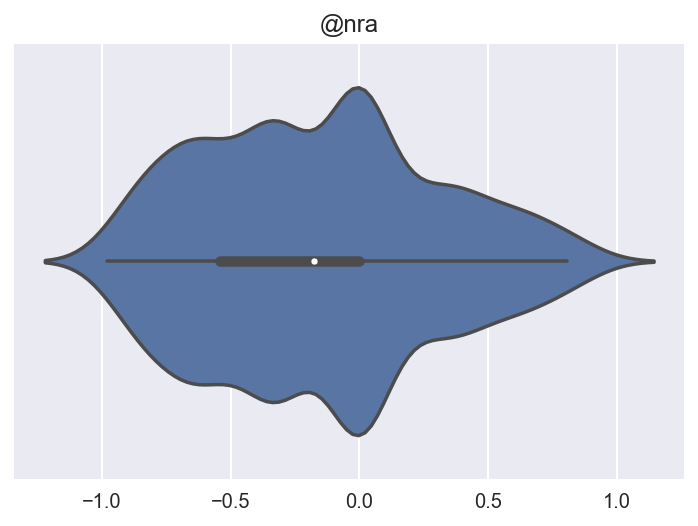

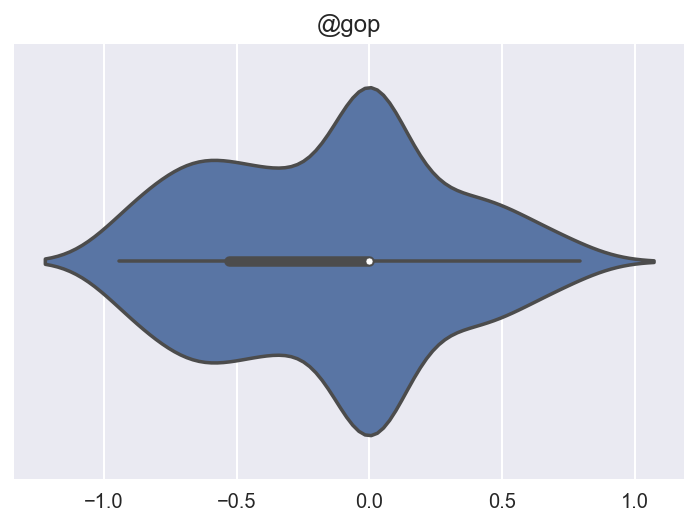

[Las Vegas]


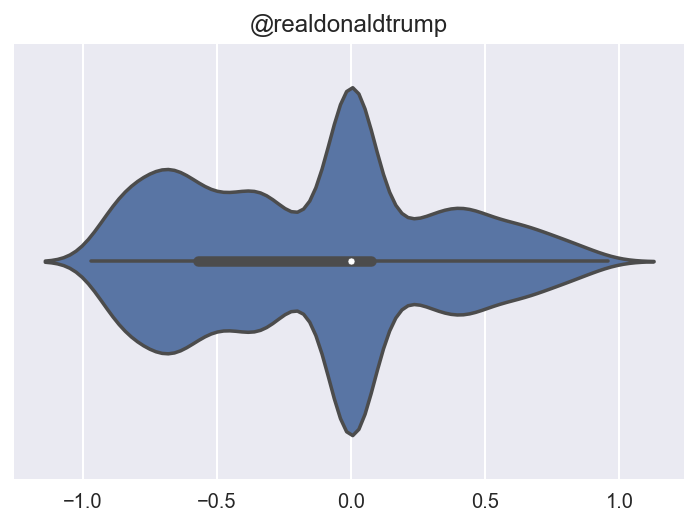

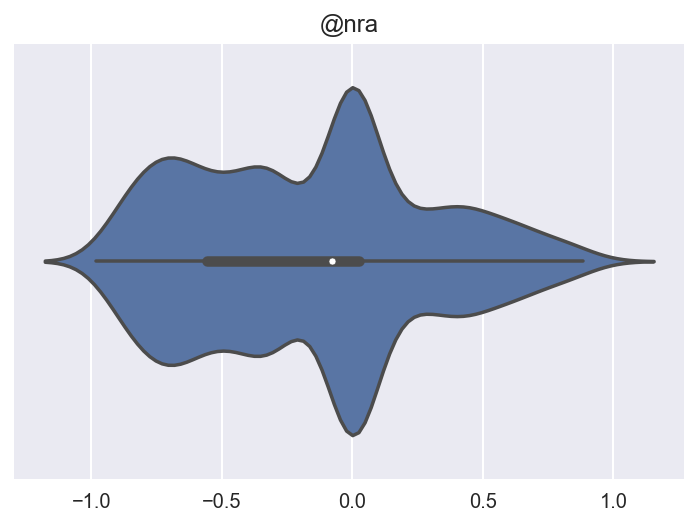

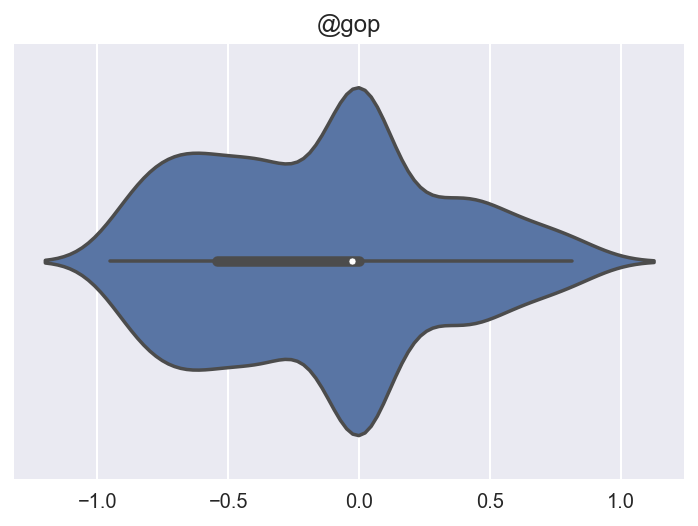

In [34]:
print("[Parkland]")
t,n,g = get_figure_tweets(p_tweets)
ts,ns,gs = get_sent_and_plot(t,n,g)
sent_plotter(ts,ns,gs)

print("[Sutherland Springs]")
t,n,g = get_figure_tweets(ss_tweets)
ts,ns,gs = get_sent_and_plot(t,n,g)
sent_plotter(ts,ns,gs)

print("[Las Vegas]")
t,n,g = get_figure_tweets(lv_tweets)
ts,ns,gs = get_sent_and_plot(t,n,g)
sent_plotter(ts,ns,gs)

The violin plots above show how overall sentiment is consistently skewed right for tweets which reference any of the three handles after any of the three mass shootings.

## 5E. Hashtag Frequency Analysis

Using hastags as a way to convey a message is one of the core functionalities of Twitter so we decided to do a timeseries analysis of the top 10 hashtags by frequency.

By using simple string manipulation (removal of punctuation, and converting to lowercase) we were able to get an accurate count of the frequencies for all hashtags in the dataset. By finding the hashtags used the most, we were trying to gauge what the overall sentiment towards the shooting. We wanted to see if certain public figures or organizations were being hashtagged, or whether certain action verbs were being used such as "#endgunviolence".

> This section builds off of code and variables which were populated in the corresponding 'Data Visualization' section (4E).

In [35]:
# Get the timestamps for each dataframe

# Vegas
end_v = max(datasets['vegas']['timestamp']).to_pydatetime()
start_v = min(datasets['vegas']['timestamp']).to_pydatetime()

# Parkland
end_p = max(datasets['parkland']['timestamp']).to_pydatetime()
start_p = min(datasets['parkland']['timestamp']).to_pydatetime()

# Sutherland
end_s = max(datasets['sutherland']['timestamp']).to_pydatetime()
start_s = min(datasets['sutherland']['timestamp']).to_pydatetime()


print("Timestamp for Vegas: {} - {}".format(start_v, end_v))
print("Timestamp for Parkland: {} - {}".format(start_p, end_p))
print("Timestamp for Sutherland: {} - {}".format(start_s, end_s))

Timestamp for Vegas: 2017-10-02 05:26:47 - 2017-10-09 05:25:15
Timestamp for Parkland: 2018-02-14 19:38:44 - 2018-02-21 19:38:38
Timestamp for Sutherland: 2017-11-05 18:39:49 - 2017-11-12 18:38:50


#### Histogram + Time Series Visualizations

The following are visualizations for the top ten most used hashtags for each of the datasets. By viewing hashtags this way we wanted to 

In [36]:
# Data visualization of the most used hashtags
def get_histogram(counts):
    
    # Get counts
    hash_tags = [x[1] for x in counts]
    hash_tag_cnt = [x[0] for x in counts]

    # Create plot
    p = figure(x_range=hash_tags[1:11], plot_height=400, title="Most Used Hashtags", toolbar_location=None, tools="")
    p.vbar(x=hash_tags[1:11], top=hash_tag_cnt[1:11], width=0.9)
    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = math.pi/3
    p.y_range.start = 0
    
    # Return plot
    return p

# function gets the hourly counts
def get_hourly_counts(df, hashTags, start, end):
    
    # Will hold hourly counts for each hashtag, dict of dict
    ht_hourly_counts = defaultdict(lambda: defaultdict(int))
    
    # For each hashtag get the hourly counts
    for ht in hashTags:
        
        # Set hour 0 to have 0 counts duh
        ht_hourly_counts[ht][0] = 0
        hour = 1
        temp_start = start
        temp_end = end
        
        # loop will go through each hour
        while temp_start <= temp_end:
            
            # get tweets from hour span
            curr_end = temp_start + datetime.timedelta(hours=1)
            tweets = df[ (df['timestamp'] >= temp_start) & (df['timestamp'] < curr_end) ]
            
            # Convert to lower case
            tweets = tweets.text.str.lower()
            
            # Use this to strip tweet of all punctuation minus "#"
            setToRemove = string.punctuation
            setToRemove = setToRemove.replace('#',"")
            pattern = r"[{}]".format(setToRemove) # create the pattern
            
            # now loop thru tweet df
            for tweet in tweets:
                
                # Strip punctuation from tweet
                tweet = re.sub(pattern, "", tweet)
                
                # Make text into list of words
                tweet = tweet.split()
                
                # If hashtag is in list of words increment count for hashtag and hour
                if ht in tweet:
                    ht_hourly_counts[ht][hour] += 1
                    
            # Increment for loop        
            hour += 1
            temp_start = curr_end
            
    # return dictionary
    return ht_hourly_counts
    
# Function plots the hourly hashtag count for a list of hashtags
def get_plot(df, hashTags, start, end):
    
    # Get hourly counts for dataframe
    ht_hourly_counts = get_hourly_counts(df, hashTags, start, end)
    
    # Now plot
    p = figure(plot_width=800, plot_height=500, title="Hourly Hashtag Growth")
    x_values = []
    y_values = []
    colors_list = Category20[10]
    
    # Get values for plot
    for ht in hashTags:
        set_values = ht_hourly_counts[ht].items()
        x_values.append( [x[0] for x in set_values] ) 
        y_values.append( [x[1] for x in set_values] )
    
    
    # Plot lines
    for (colr, leg, x, y ) in zip(colors_list, hashTags, x_values, y_values):
        my_plot = p.line(x, y, color= colr, legend= leg, line_width=2)
   
    # Label axises    
    p.xaxis.axis_label = 'Hours After Shooting'
    p.yaxis.axis_label = '# of Tweets Containing Hashtag'
    
    # return plot
    return p    

# Function prints stats of hashtag growth
def get_stats(ht_hourly_counts):
    
    # Find peak hour for each hashtag
    total_peak_hours = 0
    for ht in ht_hourly_counts:
        maxHour = max(ht_hourly_counts[ht], key=(ht_hourly_counts[ht]).get)
        total_peak_hours += maxHour
        print("Hashtag: {} \nPeak Hour: {} \n# of Tweets: {} \n".format(ht, maxHour, ht_hourly_counts[ht][maxHour]))
    
    print("Average peak hour for top 10 hashtags: {}".format(total_peak_hours/len(ht_hourly_counts)))

In [37]:
hist = get_histogram(counts_vegas)
show(hist)

In [38]:
plot = get_plot(datasets['vegas'], [x[1] for x in counts_vegas[1:11]], start_v, end_v)
show(plot)
get_stats(get_hourly_counts(datasets['vegas'], [x[1] for x in counts_vegas[1:11]], start_v, end_v))

Hashtag: #vegasshooting 
Peak Hour: 9 
# of Tweets: 2147 

Hashtag: #lasvegas 
Peak Hour: 10 
# of Tweets: 706 

Hashtag: #guncontrol 
Peak Hour: 14 
# of Tweets: 293 

Hashtag: #guncontrolnow 
Peak Hour: 10 
# of Tweets: 376 

Hashtag: #mandalaybay 
Peak Hour: 10 
# of Tweets: 480 

Hashtag: #vegasstrong 
Peak Hour: 20 
# of Tweets: 167 

Hashtag: #prayforvegas 
Peak Hour: 10 
# of Tweets: 298 

Hashtag: #nra 
Peak Hour: 21 
# of Tweets: 128 

Hashtag: #vegas 
Peak Hour: 10 
# of Tweets: 129 

Hashtag: #stephenpaddock 
Peak Hour: 11 
# of Tweets: 117 

Average peak hour for top 10 hashtags: 12.5


In [39]:
hist = get_histogram(counts_suth)
show(hist)

In [40]:
plot = get_plot(datasets['sutherland'], [x[1] for x in counts_suth[1:11]], start_s, end_s)
show(plot)
get_stats(get_hourly_counts(datasets['sutherland'], [x[1] for x in counts_suth[1:11]], start_s, end_s))

Hashtag: #sutherlandspringsshooting 
Peak Hour: 7 
# of Tweets: 419 

Hashtag: #texas 
Peak Hour: 4 
# of Tweets: 382 

Hashtag: #guncontrol 
Peak Hour: 3 
# of Tweets: 209 

Hashtag: #guncontrolnow 
Peak Hour: 6 
# of Tweets: 157 

Hashtag: #nra 
Peak Hour: 7 
# of Tweets: 73 

Hashtag: #texasshooting 
Peak Hour: 6 
# of Tweets: 75 

Hashtag: #texaschurchmassacre 
Peak Hour: 24 
# of Tweets: 59 

Hashtag: #lasvegas 
Peak Hour: 4 
# of Tweets: 55 

Hashtag: #texaschurchshooting 
Peak Hour: 4 
# of Tweets: 107 

Hashtag: #churchshooting 
Peak Hour: 4 
# of Tweets: 41 

Average peak hour for top 10 hashtags: 6.9


In [41]:
hist = get_histogram(counts_park)
show(hist)

In [42]:
plot = get_plot(datasets['parkland'], [x[1] for x in counts_park[1:11]], start_p, end_p)
show(plot)
get_stats(get_hourly_counts(datasets['parkland'], [x[1] for x in counts_park[1:11]], start_p, end_p))

Hashtag: #floridaschoolshooting 
Peak Hour: 5 
# of Tweets: 1896 

Hashtag: #parklandshooting 
Peak Hour: 4 
# of Tweets: 1069 

Hashtag: #parklandschoolshooting 
Peak Hour: 21 
# of Tweets: 1321 

Hashtag: #guncontrolnow 
Peak Hour: 3 
# of Tweets: 949 

Hashtag: #gunreformnow 
Peak Hour: 24 
# of Tweets: 812 

Hashtag: #florida 
Peak Hour: 5 
# of Tweets: 794 

Hashtag: #guncontrol 
Peak Hour: 5 
# of Tweets: 530 

Hashtag: #floridashooting 
Peak Hour: 3 
# of Tweets: 382 

Hashtag: #nra 
Peak Hour: 5 
# of Tweets: 246 

Hashtag: #parklandstrong 
Peak Hour: 31 
# of Tweets: 153 

Average peak hour for top 10 hashtags: 10.6


## 6. Privacy / Ethics Considerations

 * Even if we drop names, locations, usernames, and all other information that complies with the Safe Harbor Method, it’s still possible to identify the creators of the tweet because this is all publicly available data.
 * Another issue is if users choose to privatize their accounts after their tweets have been scraped. It’s important to respect a user’s desire to privatize their information, but this is hard to monitor once the data has already been scraped and isn’t very up-to-date.
 * It’s fine to use Twitter data for research as long as we follow their guidelines (https://developer.twitter.com/en/developer-terms/agreement-and-policy), such as not sharing the scraped data with any third-parties.
 * Because data is only being gathered from Twitter, our data is limited only to people that use this platform to voice out their thoughts and opinions. The data, therefore, isn’t a very accurate representation of the overall sentiment regarding the different shootings and could possibly be biased in one direction - people who are more adept with technology and are in a younger age demographic, as well as people who can not afford technology to voice their opinions.


## 7. Conclusions and Discussion

The techniques used above span the fields of machine learning, statistics and linguistics, which can be transferred to other domains within NLP and Data Science. If we were able to have access to the Twitter “waterhose” API, we would be able to perform additional analysis on larger datasets, potentially unrelated to the events that transpired as detailed above.

Some of the technology choices, could have hindered our progress and development time. For example, we could have downloaded a sample Twitter dataset, that comes with labels - and trained a more conventional SVM sentiment analyzer on that dataset, then used the trained model on our dataset. Furthermore, running trigram analyzers on a corpus would have increased its effectiveness. Perhaps, appending all the tweets together to create an artificial corpus, and then running the collocation analysis could have yielded better results.

Some confounds in this experiment were that we were limited in the amount of tweets we were able to scrape. We did not take into account those tweets that either did not use hashtags being analyzed, or misspelled those hashtags. Another major issue we did not address are tweets originated from Twitter bots. This could play a huge factor in our sentiment analysis of the tweet text. Finally, we did not correct our numbers to account for potential growth in the overall number of Twitter users over time. All in all these factors might make an impact on our findings but they were not detrimental, rendering our conclusions pointless.

Moreover, a more crucial factor regarding the platform itself is that Twitter does not capture the entire sentiment and opinion of the entire population. Due to recent proliferation of social sedia technology, networks such as Twitter and Facebook have been able to characterize large portions, but subsets such as the elderly and the poor may not have the ability to access/skills necessary to post to Twitter.

___

After the visualization and analysis of over 300,000 tweets and the use of many Natural Language processing frameworks, we were able to characterize trends in public sentiment and activity regarding three recent mass shootings. We found that after any of these shootings, users would use the social media platform to voice their discontent with lawmakers and current policy regarding Gun Reform - with both lawmakers, particularly of the Republican party being the most mentioned. Hashtags such as “#GunControlNow” highlight twitter’s ability as a changemaking agent, putting pressure on government and agencies such as the NRA. Although individual opinion regarding these events can be polarized on either side of the political spectrum, overall sentiment was skewed towards the negative side. It is understandable given the gravity of the situation, and is in-line with our original hypothesis.

Furthermore, we uncovered the fact that these mass shootings tend to fall out of the public eye fairly quickly on social media. While the idea of a constant “news cycle” in American media and in the public eye is generally spoken about and agreed upon, the visualized precipitous decline in social media coverage over time was alarmingly unexpected. In the case of Las Vegas and Sutherland Springs shootings, tweet volume fell almost 75% within the first 48 hours after the shooting.

Finally, we believe an objective analysis of public activity on social media platforms, such as the one above, can have potential for civic benefit. Lawmakers and politicians are clearly being mentioned and called-out on social media platforms; potential avenues for further action can be generated by further analysis of data for as a real-time, up-to-date brief of public opinion on related issues surrounding public tragedies, such as gun reform and school safety. We hope that as the use of technology continues to increase, that data be more integrated into society and applications such as government.